# Correlation between physiological synapse parameters

Implementation and testing of how to add correlations between physiological synapse parameters, as in [Chindemi et al. 2022].

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

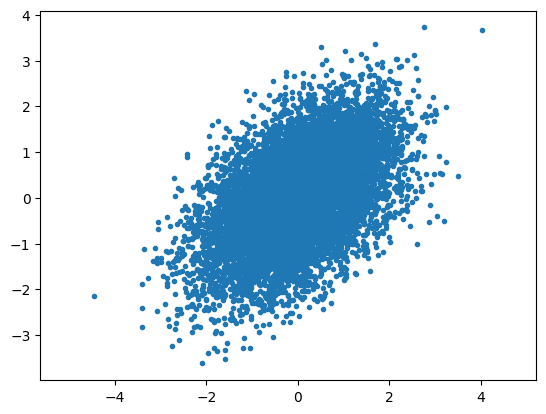

In [2]:
# Example with two parameters
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]

np.random.seed(0)
samples = np.random.multivariate_normal(mean, cov, size=10000)
plt.figure()
plt.plot(samples[:, 0], samples[:, 1], ".")
plt.axis("equal")
plt.show()

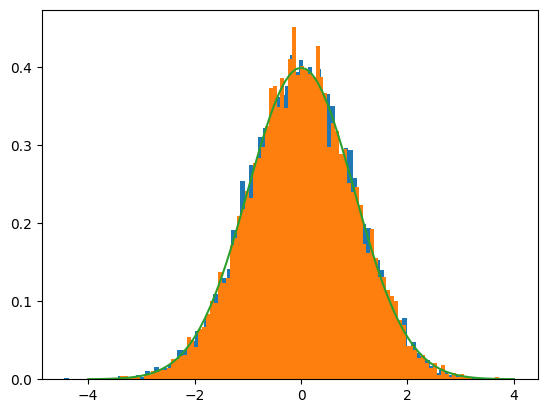

In [3]:
# Marginals
plt.figure()
plt.hist(samples[:, 0], bins=100, density=True)
plt.hist(samples[:, 1], bins=100, density=True)
x = np.arange(-4, 4.1, 0.1)
plt.plot(x, sts.norm.pdf(x))
plt.show()

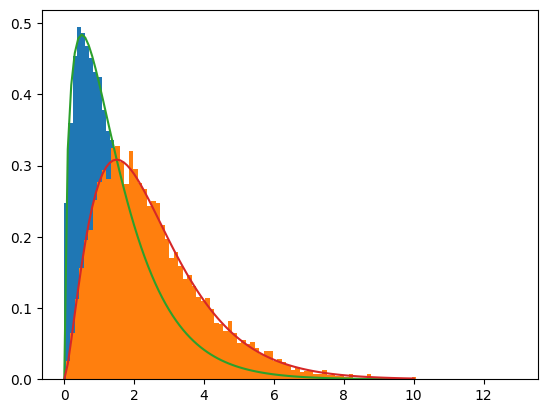

In [4]:
# Map to gamma distributions
a_gamma = [1.5, 2.5]
samples_remapped = np.array([sts.gamma.isf(1 - sts.norm.cdf(samples[:, _i]), _a) for _i, _a in enumerate(a_gamma)]).T

# Marginals
plt.figure()
plt.hist(samples_remapped[:, 0], bins=100, density=True)
plt.hist(samples_remapped[:, 1], bins=100, density=True)
x = np.arange(0, 10.1, 0.1)
plt.plot(x, sts.gamma.pdf(x, a_gamma[0]))
plt.plot(x, sts.gamma.pdf(x, a_gamma[1]))
plt.show()

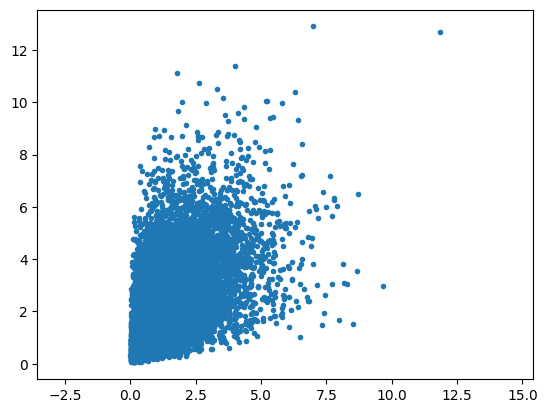

In [5]:
plt.figure()
plt.plot(samples_remapped[:, 0], samples_remapped[:, 1], ".")
plt.axis("equal")
plt.show()

In [6]:
np.cov(samples.T)

array([[0.98969614, 0.49947156],
       [0.49947156, 0.98124775]])

In [7]:
np.cov(samples_remapped.T)

array([[1.4567793 , 0.89335524],
       [0.89335524, 2.45003301]])

In [6]:
# Check ConnPropsModel
from connectome_manipulator.model_building import model_types

In [39]:
# Parameterization for L23 PC to L23 PC from [Isbister et al. 2023, Tab. S2]
# gsyn ... ~gamma (1.0±0.5 nS)
# nrrp ... ~poisson (2.6)
# [u ... ~truncnorm (0.46±0.26)]

stats_dict = {
    "gsyn": {"L23_PC": {"L23_PC": {"type": "gamma", "mean": 1.0, "std": 0.5, "shared_within": False}}},
    "nrrp": {"L23_PC": {"L23_PC": {"type": "poisson", "mean": 2.6, "shared_within": False}}},
    "u": {"L23_PC": {"L23_PC": {"type": "truncnorm", "norm_loc": 0.46, "norm_scale": 0.26, "min": 0.2, "max": 0.72, "shared_within": False}}}
}
# cov_dict = {
#     "props": ["gsyn", "nrrp"],
#     "cov": {"L23_PC": {"L23_PC": np.array([[1.0, 0.9], [0.9, 1.0]])}}
# }
# cov_dict = {
#     "props": ["gsyn", "u"],
#     "cov": {"L23_PC": {"L23_PC": np.array([[1.0, 0.9], [0.9, 1.0]])}}
# }
cov_dict = {
    "props": ["gsyn", "nrrp", "u"],
    "cov": {"L23_PC": {"L23_PC": np.array([[1.0, 0.9, 0.9], [0.9, 1.0, 0.81], [0.9, 0.81, 1.0]])}}
}

model = model_types.ConnPropsModel(src_types=["L23_PC"], tgt_types=["L23_PC"], prop_stats=stats_dict)
print(model)

model_cov = model_types.ConnPropsModel(src_types=["L23_PC"], tgt_types=["L23_PC"], prop_stats=stats_dict, prop_cov=cov_dict)
print(model_cov)

ConnPropsModel (w/o #syn/conn)
  Connection/synapse property distributions between 1x1 M-types:
  gsyn <gamma>; nrrp <poisson>; u <truncnorm>
ConnPropsModel (w/o #syn/conn)
  Connection/synapse property distributions between 1x1 M-types:
  gsyn <gamma>; nrrp <poisson>; u <truncnorm>
  Correlated properties: gsyn, nrrp, u


In [40]:
# Draw values
N = 10000
syn_vals = model.apply(src_type="L23_PC", tgt_type="L23_PC", n_syn=N)
syn_vals_cov = model_cov.apply(src_type="L23_PC", tgt_type="L23_PC", n_syn=N)

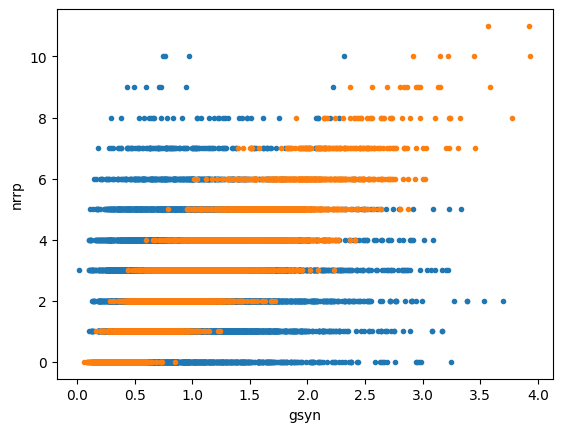

In [41]:
plt.figure()
plt.plot(syn_vals["gsyn"], syn_vals["nrrp"], ".", label="W/o COV")
plt.plot(syn_vals_cov["gsyn"], syn_vals_cov["nrrp"], ".", label="W/ COV")
plt.xlabel("gsyn")
plt.ylabel("nrrp")
plt.show()

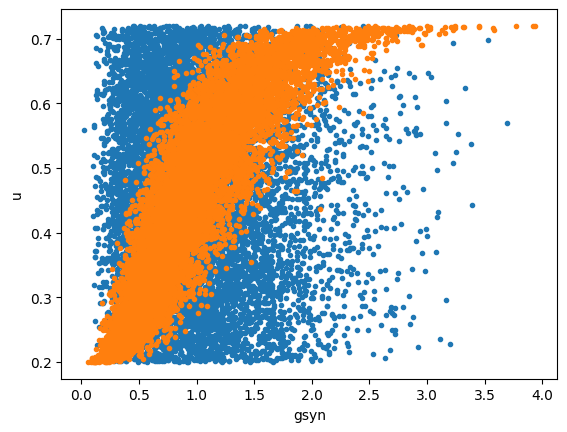

In [42]:
plt.figure()
plt.plot(syn_vals["gsyn"], syn_vals["u"], ".", label="W/o COV")
plt.plot(syn_vals_cov["gsyn"], syn_vals_cov["u"], ".", label="W/ COV")
plt.xlabel("gsyn")
plt.ylabel("u")
plt.show()

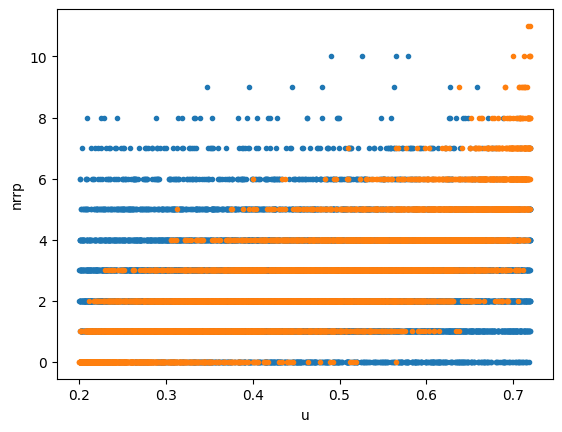

In [43]:
plt.figure()
plt.plot(syn_vals["u"], syn_vals["nrrp"], ".", label="W/o COV")
plt.plot(syn_vals_cov["u"], syn_vals_cov["nrrp"], ".", label="W/ COV")
plt.xlabel("u")
plt.ylabel("nrrp")
plt.show()